# $\tau$ and delayed-$\tau$ model sanity checks
In this notebook I will check that the SFH are sensible and integrate to 1. I will check that the average SSFR does not exceed $1/dt$

In [1]:
import numpy as np 
from provabgs import infer as Infer
from provabgs import models as Models
from astropy.cosmology import Planck13

In [2]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
tau_model = Models.FSPS(name='tau') # tau model
dtau_model = Models.FSPS(name='delayed_tau') # delayed tau model 

In [4]:
zred = 0.01
tage = Planck13.age(zred).value

In [5]:
prior = Infer.load_priors([
        Infer.UniformPrior(0., 0.), 
        Infer.UniformPrior(0.3, 1e1), # tau SFH
        Infer.UniformPrior(0., 0.2), # constant SFH
        Infer.UniformPrior(0., tage-2.), # start time
        Infer.UniformPrior(0., 0.5),  # fburst
        Infer.UniformPrior(0., tage),  # tburst
        Infer.UniformPrior(1e-6, 1e-3), # metallicity
        Infer.UniformPrior(0., 4.)])

## Check SFH sensibility

In [6]:
np.random.seed(2)

In [7]:
theta = prior.sample()
print('tau = %.2f' % theta[1])
print('tstart = %.2f' % theta[3])
print('tburst = %.2f' % theta[5])

tau = 7.81
tstart = 5.79
tburst = 12.39


In [8]:
t1, sfh1 = tau_model.SFH(theta, zred)
t2, sfh2 = dtau_model.SFH(theta, zred)

(0.0, 13.653058838303744)

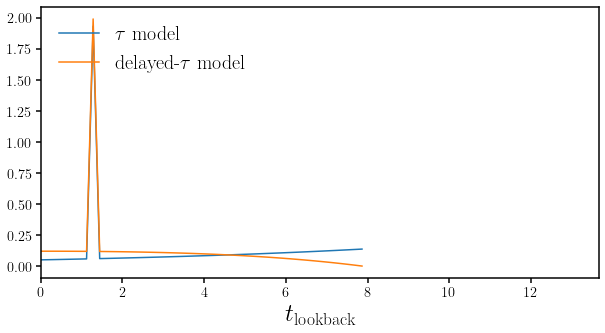

In [9]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(t1, sfh1, label=r'$\tau$ model')
sub.plot(t2, sfh2, label=r'delayed-$\tau$ model')
sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel(r'$t_{\rm lookback}$', fontsize=25)
sub.set_xlim(0., tage)

## check SFH normalization

In [10]:
for i in range(100): 
    theta = prior.sample()
    t1, sfh1 = tau_model.SFH(theta, zred)
    t2, sfh2 = dtau_model.SFH(theta, zred) 
    assert np.abs(np.trapz(sfh1, t1) - 1) < 1e-4, ('int(SFH) = %f' % np.trapz(sfh1, t1))
    assert np.abs(np.trapz(sfh2, t2) - 1) < 1e-4, ('int(SFH) = %f' % np.trapz(sfh2, t2))

## check average SFR calculation 

In [16]:
thetas = np.array([prior.sample() for i in range(50000)])
avgsfr1 = tau_model.avgSFR(thetas, zred, dt=0.1)
avgsfr2 = dtau_model.avgSFR(thetas, zred, dt=0.1)

(-13.0, -7.0)

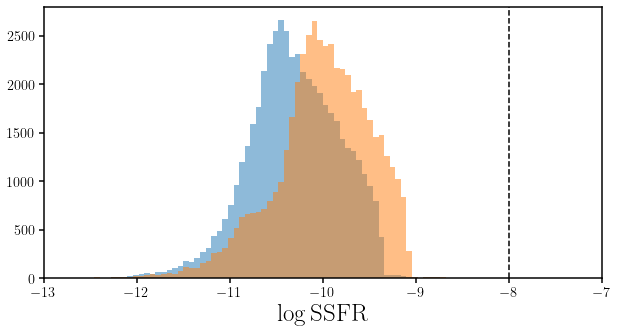

In [12]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.hist(np.log10(avgsfr1), range=(-13, -7), bins=100, alpha=0.5)
sub.hist(np.log10(avgsfr2), range=(-13, -7), bins=100, alpha=0.5)
sub.axvline(-8, color='k', linestyle='--')
sub.set_xlabel(r'$\log{\rm SSFR}$', fontsize=25)
sub.set_xlim(-13., -7.)

In [13]:
avgsfr1 = tau_model.avgSFR(thetas, zred, dt=1)
avgsfr2 = dtau_model.avgSFR(thetas, zred, dt=1)

(-13.0, -7.0)

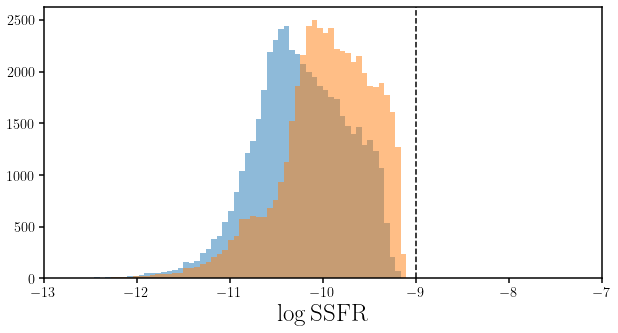

In [14]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.hist(np.log10(avgsfr1), range=(-13, -7), bins=100, alpha=0.5)
sub.hist(np.log10(avgsfr2), range=(-13, -7), bins=100, alpha=0.5)
sub.axvline(-9, color='k', linestyle='--')
sub.set_xlabel(r'$\log{\rm SSFR}$', fontsize=25)
sub.set_xlim(-13., -7.)

None exceed the theoretical SSFR limit